# Crop Identification and Disease Recognition
## Machine Learning Models
## Image Classification with Naive Bayes and Random Forest
#### Analysis by Ben Geissel

## Introduction
Fill in Text Text Text (mention data size)

In [1]:
# Import necessary packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import os
from PIL.Image import core as image
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
import scikitplot as skplt
import image_processing

## Data Exploration
Image Count by Class

In [2]:
# Run through image files and determine if any are the wrong shape
# Count images by crop/disease type
data_path = 'PlantVillage-Dataset/raw_image_data/color'
diff_shape_count = 0
img_count = 0
leaf_type_img_count = 0
leaf_type_img_count_dict = {}
for folder in os.listdir(data_path):
    for image in os.listdir('%s/%s' % (data_path, folder)):
        img_loc = '%s/%s/%s' % (data_path, folder, image)
        img = Image.open(img_loc)
        arr = np.array(img)
        img_shape = arr.shape
        img_count += 1
        leaf_type_img_count += 1
        if img_shape != (256, 256, 3):
            diff_shape_count += 1
            print(img_loc)
            print(img_shape)
        else:
            continue
    leaf_type_img_count_dict[folder] = leaf_type_img_count
    leaf_type_img_count = 0
print('Wrong Shape Image Count: %d' % (diff_shape_count))
print('Total Color Image Count: %d' % (img_count))
print()

Wrong Shape Image Count: 0
Total Color Image Count: 54304



Barchart showing spread of images by class

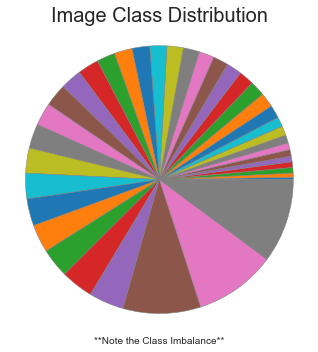

In [67]:
# Create horizontal barplot of image class distribution
sorted_class_dict = dict(zip(sorted(leaf_type_img_count_dict, key = leaf_type_img_count_dict.get), sorted(leaf_type_img_count_dict.values())))
sns.set_style('darkgrid')
plt.figure(figsize = (5,5))
# plt.barh(range(len(sorted_class_dict)), sorted_class_dict.values(), tick_label = list(sorted_class_dict.keys()), align='center', color = 'darkblue')
plt.pie(sorted_class_dict.values(), radius = 1.1, wedgeprops = {'linewidth' : .5, 'edgecolor' : 'gray'})
plt.title('Image Class Distribution', fontsize = 20)
plt.xlabel('**Note the Class Imbalance**')
plt.tight_layout()
plt.show()

In [47]:
# Calculate Class Percentages
class_percent_dict = {}
for key in sorted_class_dict.keys():
    class_percent_dict[key] = round((sorted_class_dict[key] / img_count) * 100, 2)
top3class = (class_percent_dict['Soybean___healthy'] + 
             class_percent_dict['Tomato___Tomato_Yellow_Leaf_Curl_Virus'] +
             class_percent_dict['Orange___Haunglongbing_(Citrus_greening)'])
print(round(top3class, 2),'%')

29.37 %


### Tomato Example:
Tomato leaves are a fun example since there are 10 separate classes of tomato leaf images (1 healthy, 9 diseases). The following cells show the distribution of tomato classes in the dataset.

In [71]:
# Generate Tomato class dictionary for barplot
tomato_class_dict = {}
tomato_img_count = 0
for key in list(sorted_class_dict.keys()):
    if key[:6] == 'Tomato':
        tomato_class_dict[key] = sorted_class_dict[key]
        tomato_img_count += sorted_class_dict[key]
    else:
        continue
print('# of Tomato Images:', tomato_img_count)
print('Tomato Percentage:', round((tomato_img_count / img_count) * 100, 2), '%')

# of Tomato Images: 18160
Tomato Percentage: 33.44 %


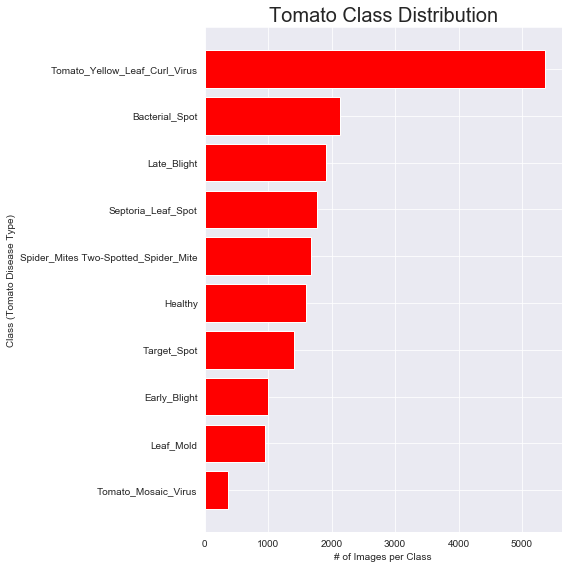

In [75]:
# Create horizontal barplot of tomato class distribution
plt.figure(figsize = (8,8))
plt.barh(range(len(tomato_class_dict)), tomato_class_dict.values(),
         tick_label = [str.title(x[9:]) for x in list(tomato_class_dict.keys())],
         align='center', color = 'red')
plt.title('Tomato Class Distribution', fontsize = 20)
plt.ylabel('Class (Tomato Disease Type)')
plt.xlabel('# of Images per Class')
plt.tight_layout()
plt.show()

## Data Preparation
In additon to the data cleaning preparation step below, I would have liked to attempt Principal Component Analysis (PCA) in order to reduce the dimensionality of my dataset (each image currently an array with 196,608 pixel values). Unfortunately, even with cloud computing (96 CPUs and 4 GPUs), I was unable to get PCA to run.

In the following cells, I will generate arrays for both the image data and class data. The images are converted into flattened numpy arrays.

In [3]:
# Run through image files and convert to flattened pixel array and add to list
# Create target list
data_list = []
target_list = []
data_path = 'PlantVillage-Dataset/raw_image_data/color'
for folder in os.listdir(data_path):
    for image in os.listdir('%s/%s' % (data_path, folder)):
        img_loc = '%s/%s/%s' % (data_path, folder, image)
        img_flat_arr = image_processing.image_to_flat_array(img_loc)
        data_list.append(img_flat_arr)
        target_list.append(folder)

In [4]:
# Convert list to array
data_array = np.array(data_list)
target_array = np.array(target_list)

Split the data into training and testing sets with an 80/20 split. Use a random state for reproduction.

In [5]:
# Train Test Validation Split - 20% testing data, 80% training data
X_train, X_test, y_train, y_test = train_test_split(data_array, target_array,
                                                    test_size = .2, random_state = 14)

## Modeling
In the following cells, Machine Learning algorithms will be used to attempt to classify the images into the 38 respective classes. Multinomial Naive Bayes and Random Forest classifiers have been shown to be effective in simple image classification problems, so I will attempt them here. Support Vector Machine models also typically perform well for image classification, however I was unable to get a SVM to run without crashing even using cloud computing.

Results below show performance metrics and confusion matrices for Naive Bayes and Random Forest. The Random Forest model performs significantly better than Naive Bayes.

In [6]:
# Fit and Score Multinomial Naive Bayes
MNB_classifier = MultinomialNB()
MNB_classifier.fit(X_train, y_train)
y_hat_test = MNB_classifier.predict(X_test)
prec = precision_score(y_test, y_hat_test, average = 'weighted')
recall = recall_score(y_test, y_hat_test, average = 'weighted')
acc = accuracy_score(y_test, y_hat_test)
f1 = f1_score(y_test, y_hat_test, average = 'weighted')
print("Model Metrics:")
print("Precision: ", prec)
print("Recall: ", recall)
print("Accuracy: ", acc)
print("F1_Score: ", f1)

Model Metrics:
Precision:  0.4746527129395343
Recall:  0.3545714022649848
Accuracy:  0.3545714022649848
F1_Score:  0.3670796611842375


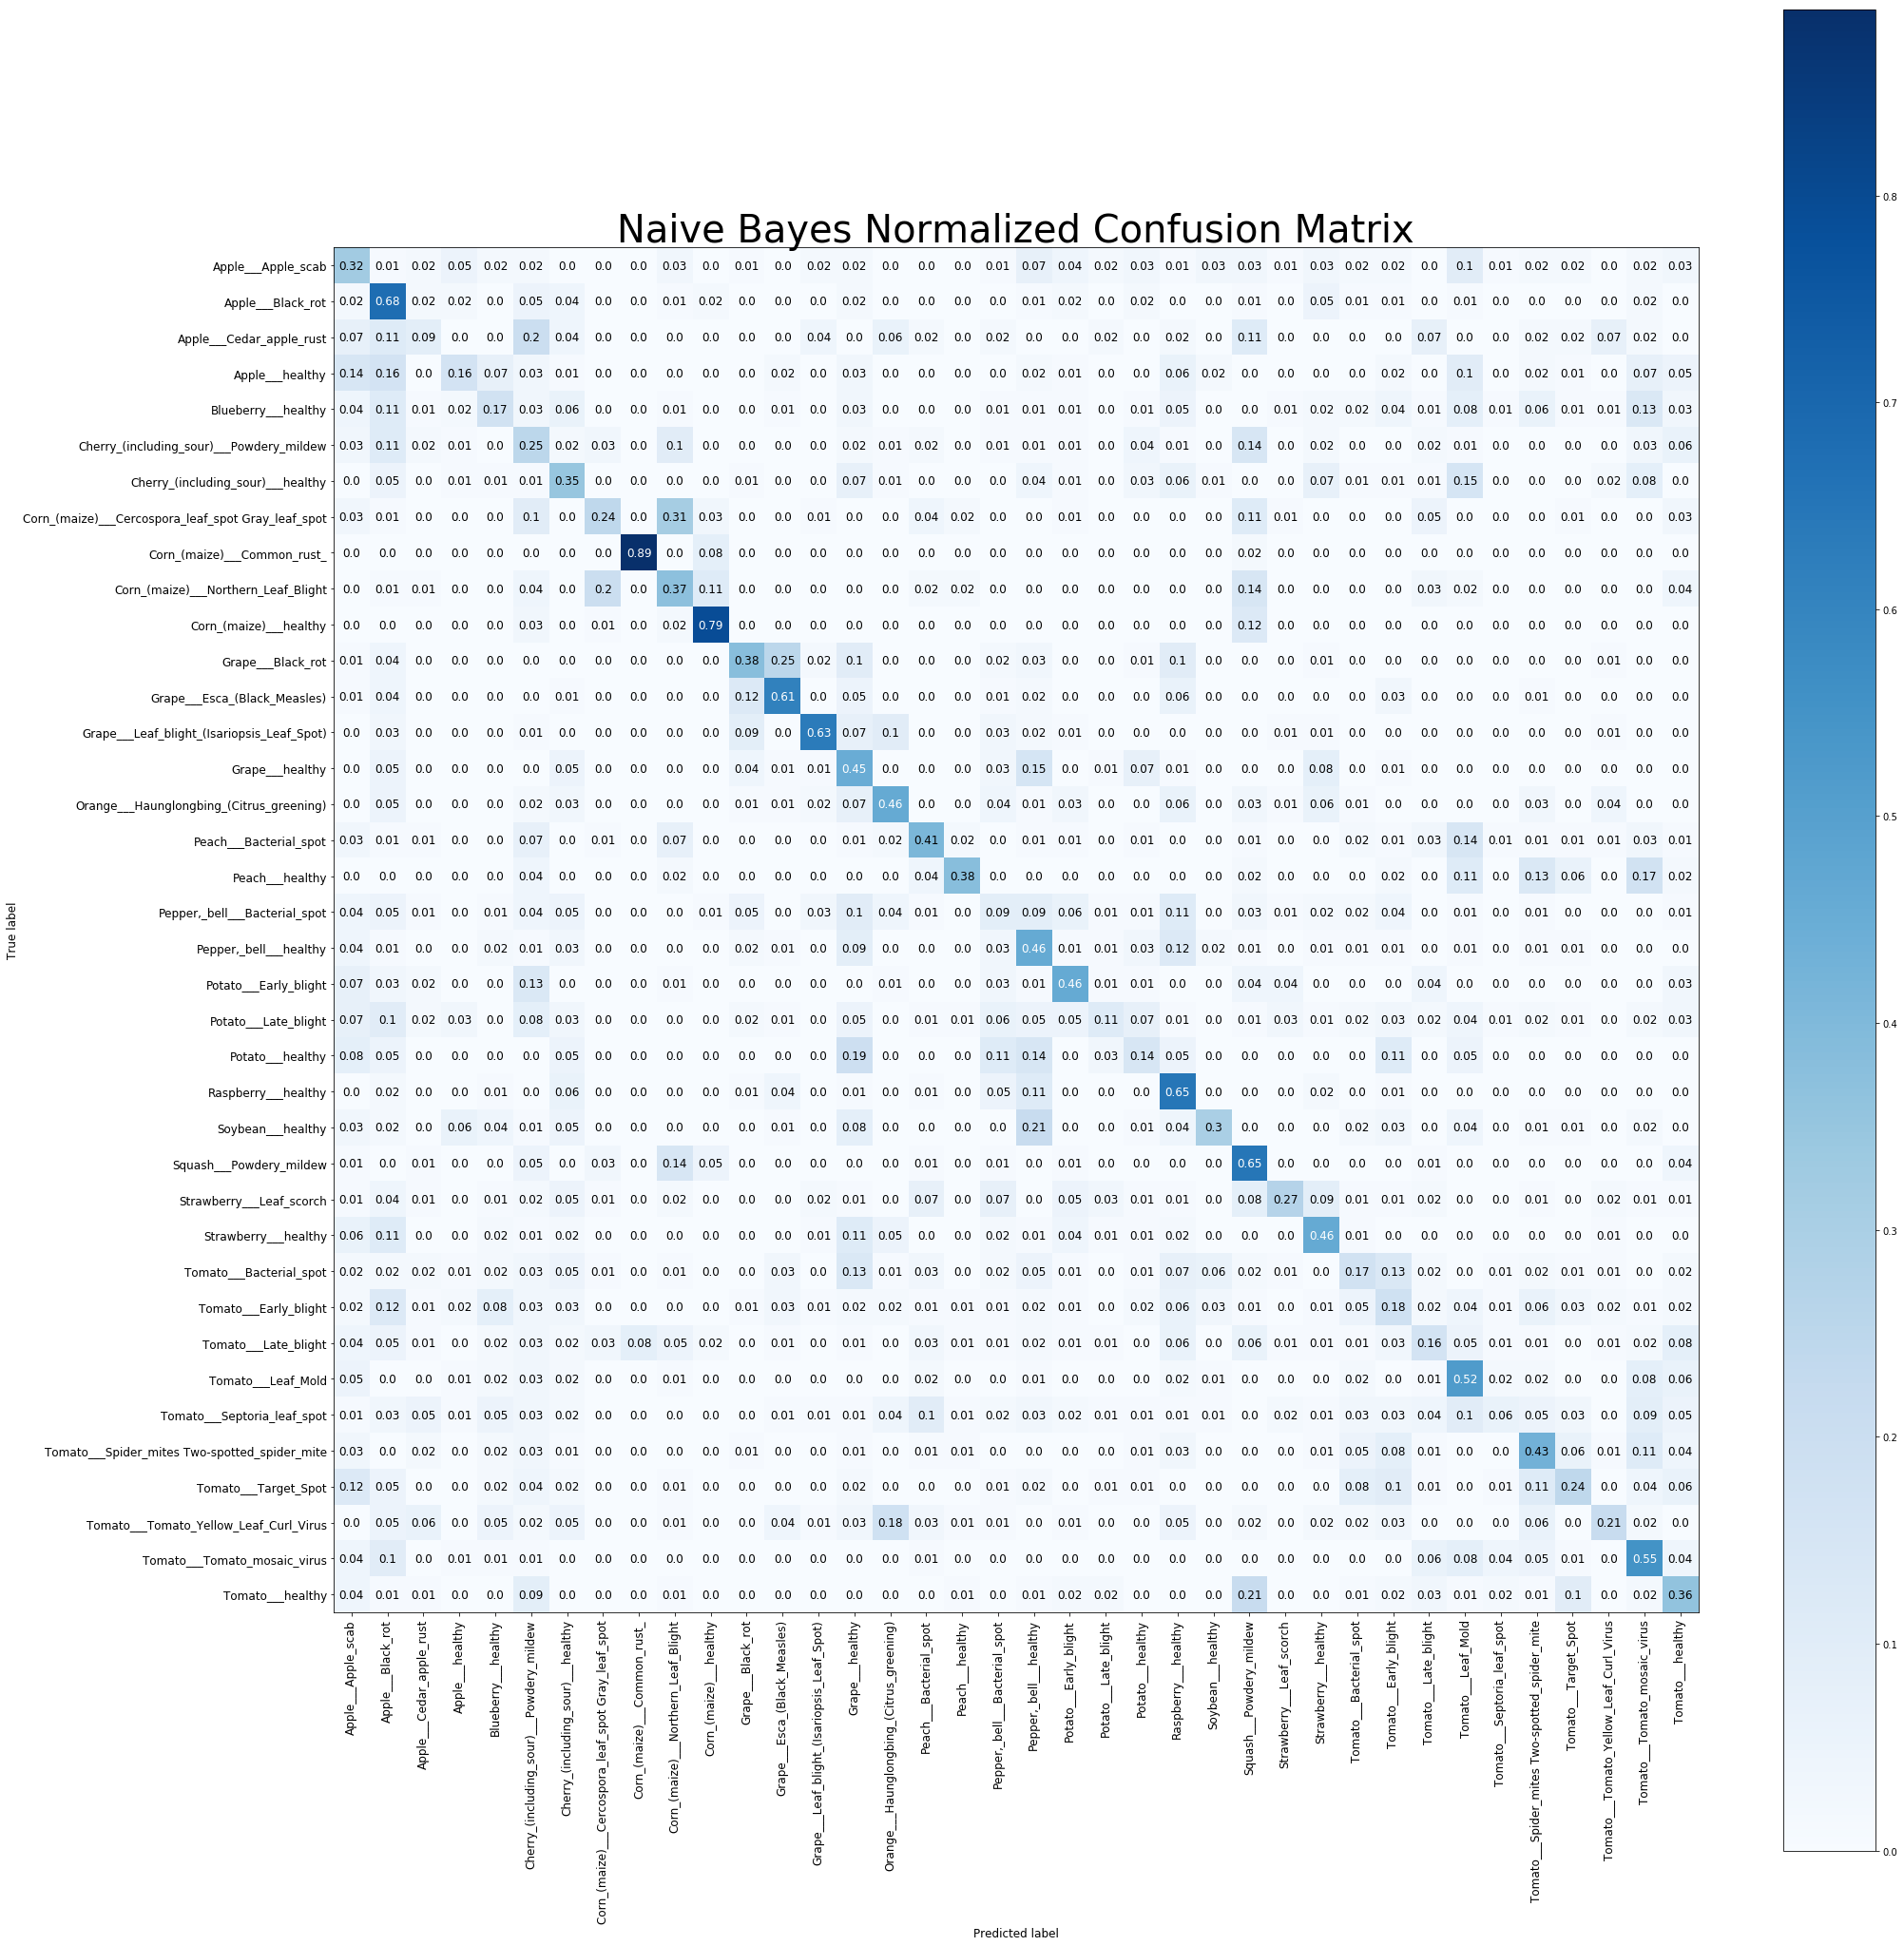

In [7]:
# Plot Confusion Matrix
skplt.metrics.plot_confusion_matrix(y_test, y_hat_test, figsize = (30,30), normalize = True, x_tick_rotation = 90,
                                    title = 'Naive Bayes Normalized Confusion Matrix', title_fontsize = 40, text_fontsize = 12)
plt.tight_layout()
plt.show()

In [8]:
# Fit and Score Random Forest
RF_classifier = RandomForestClassifier(n_estimators = 100, n_jobs = -1)
RF_classifier.fit(X_train, y_train)
y_hat_test = RF_classifier.predict(X_test)
prec = precision_score(y_test, y_hat_test, average = 'weighted')
recall = recall_score(y_test, y_hat_test, average = 'weighted')
acc = accuracy_score(y_test, y_hat_test)
f1 = f1_score(y_test, y_hat_test, average = 'weighted')
print("Model Metrics:")
print("Precision: ", prec)
print("Recall: ", recall)
print("Accuracy: ", acc)
print("F1_Score: ", f1)

Model Metrics:
Precision:  0.6403465223041268
Recall:  0.6380627934812633
Accuracy:  0.6380627934812633
F1_Score:  0.600917453113953


/usr/local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


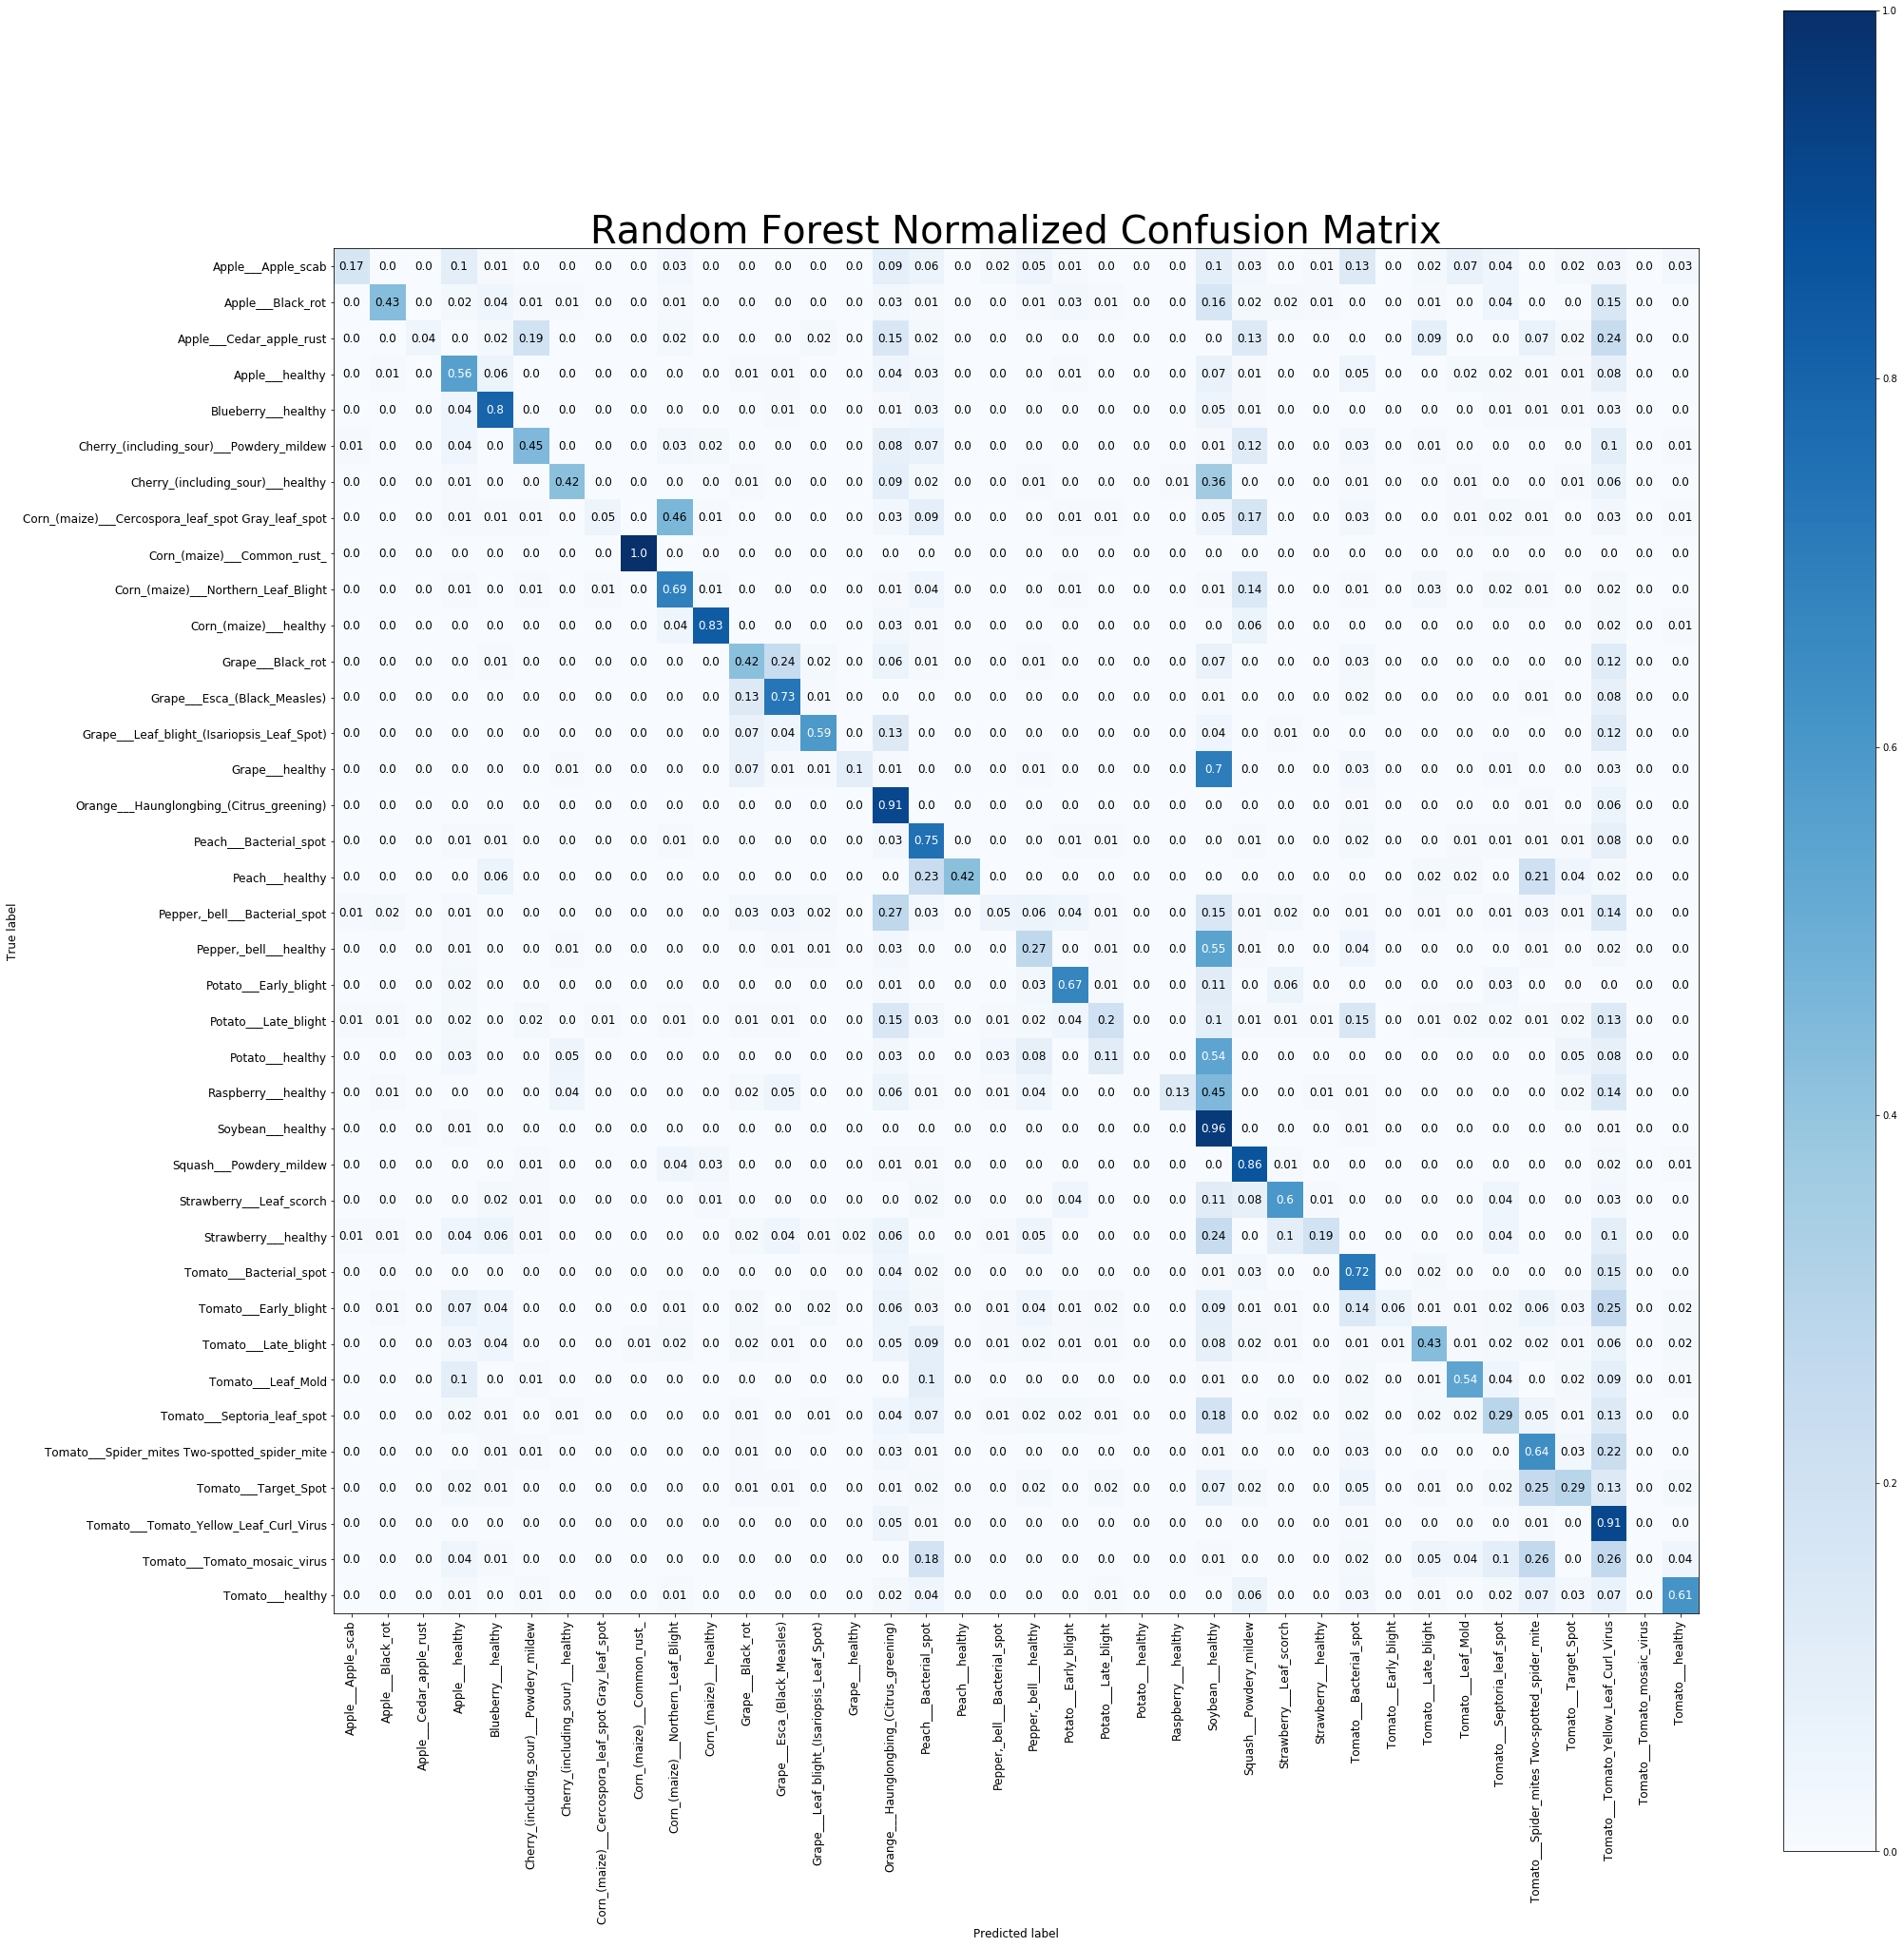

In [9]:
# Plot Confusion Matrix
skplt.metrics.plot_confusion_matrix(y_test, y_hat_test, figsize = (30,30), normalize = True, x_tick_rotation = 90,
                                    title = 'Random Forest Normalized Confusion Matrix', title_fontsize = 40, text_fontsize = 12)
plt.tight_layout()
plt.show()

## Conclusions

Text Text Text (mention downfalls of Machine Learning Models and need for Deep Learning CNN)